## Spatial Joins

A Spatial join is a GIS operation that affixes data from one feature layer’s attribute table to another from a spatial perspective. Spatial joins begin by selecting a target feature and comparing it spatially to other feature layers. The target features will inherit the attributes from the other features if and only if the two features share the same spatial reference. Spatial join is a way that data from one feature class can be easily added to another feature class. 

Spatial joins uses [binary predictions](http://toblerity.org/shapely/manual.html#binary-predicates) such as contains and intersects to combine two Geodataframes based on the spatial relationship between the geometries.

### Types of spatial joins

*** Note that left refers to the dataframe mentioned first (on the left) and right refers to the the dataframe metioned second (or on the right as you are reading the dataframes)

#### Left outer join

In a LEFT OUTER JOIN, *All* rows from the left are kept and duplicated if necessary to represent multiple hits between the two dataframes. Right rows are retained if they *intersect* a left row and are lost if they do not. A left outer join implies an interest in retaining the geometries of the left. 

![Left join ven diagram](https://www.codeproject.com/KB/database/Visual_SQL_Joins/LEFT_JOIN.png)

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
LEFT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
 0101000000818693BA2F8FF7BF4ADD97C75604E9BF |    1 |       
(5 rows)
```


#### Right outer join

In a RIGHT OUTER JOIN, *All* rows from the right are kept and duplicated if necessary to represent multiple hits between the two dataframes. Left rows are retained if they *intersect* a right row and are lost if they do not. A right outer join implies an interest in retaining the geometries of the right. 

![right join ven diagram](https://www.codeproject.com/KB/database/Visual_SQL_Joins/RIGHT_JOIN.png)

This is equivalent to the PostGIS query:
```
SELECT polys.geom, pts.id as ptid, polys.id as polyid  
FROM pts
RIGHT OUTER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

  geom    | ptid | polyid 
----------+------+--------
 01...9BF |    4 |     10
 01...9BF |    3 |     10
 02...7BF |    3 |     20
 02...7BF |    2 |     20
 00...5BF |      |     30
(5 rows)
```

#### Inner join

In an INNER JOIN, rows from the right and left are only kept where their binary predicate is `True`. We duplicate them if necessary to represent multiple hits between the two dataframes. Attributes of the right and left are only retained if they *intersect* and are lost if they do not. An inner join implies an interest in retaining the geometries that overlap.

![inner join ven diagram](https://www.codeproject.com/KB/database/Visual_SQL_Joins/INNER_JOIN.png)

This is equivalent to the PostGIS query:
```
SELECT pts.geom, pts.id as ptid, polys.id as polyid  
FROM pts
INNER JOIN polys
ON ST_Intersects(pts.geom, polys.geom);

                    geom                    | ptid | polyid 
--------------------------------------------+------+--------
 010100000040A9FBF2D88AD03F349CD47D796CE9BF |    4 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     10
 010100000048EABE3CB622D8BFA8FBF2D88AA0E9BF |    3 |     20
 0101000000F0D88AA0E1A4EEBF7052F7E5B115E9BF |    2 |     20
(4 rows) 
```

Now lets load some data and see these joins in action. Once again we will be using the NYC data

 * [NYC Borough Boundaries](https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile) - See it in action [here](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
 * [NYC Wi-Fi Hotspot Locations](https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=Shapefile) - See it in action [here](https://data.cityofnewyork.us/Social-Services/NYC-Wi-Fi-Hotspot-Locations/a9we-mtpn)




In [3]:
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
from random import randint, uniform
import matplotlib.pyplot as plt

import urllib.request
import shutil
from pathlib import Path
from zipfile import ZipFile

import geopandas as gpd

In [4]:
# Designate the URL for a file
file_URL = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'

# Designate the local filename
local_file_name = 'nyc_boroughs.zip'

# Designate the local file name with a path to a temp directory.
     # Your Repo comes with this folder.  If not, use terminal and 
     # navigate to course folder > module3 and them : mkdir temp
file_Path = Path('../temp/')  
file_Path /= local_file_name

# Download the file from `url` and save it locally under `file_Path`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)

# unzip file
to_unzip = ZipFile('../temp/nyc_boroughs.zip', 'r')
unzipped = '../temp/nyc_boroughs_unzipped'
to_unzip.extractall(unzipped)
to_unzip.close()
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file

NYC = gpd.GeoDataFrame.from_file(shape_file)        

In [5]:
# Designate the URL for a file
file_URL = 'https://data.cityofnewyork.us/api/geospatial/a9we-mtpn?method=export&format=Shapefile'

# Designate the local filename
local_file_name = 'nyc_wifi.zip'

# Designate the local file name with a path to a temp directory.
     # Your Repo comes with this folder.  If not, use terminal and 
     # navigate to course folder > module3 and them : mkdir temp
file_Path = Path('../temp/')  
file_Path /= local_file_name

# Download the file from `url` and save it locally under `file_Path`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)

# unzip file
to_unzip = ZipFile('../temp/nyc_wifi.zip', 'r')
unzipped = os.getcwd() + '/nyc_wifi_unzipped'
to_unzip.extractall(unzipped)
to_unzip.close()
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file

# Read data into GeoDataFrame and view data
NYC_wifi = gpd.GeoDataFrame.from_file(shape_file)

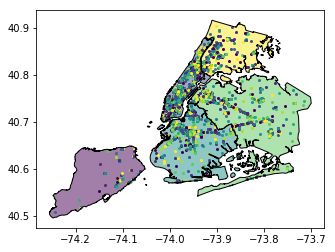

In [6]:
NYC.plot(ax=NYC_wifi.plot())    

Once again we are also going to seperate the boroughs to showcase the joins better. 

In [8]:
Staten_Island = NYC[NYC['boro_name'] == 'Staten Island']
Manhattan = NYC[NYC['boro_name'] == 'Manhattan']
Brooklyn = NYC[NYC['boro_name'] == 'Brooklyn']
Queens = NYC[NYC['boro_name'] == 'Queens']
Bronx = NYC[NYC['boro_name'] == 'Bronx']

## Joins

In [9]:
from geopandas.tools import sjoin
join_left_df = sjoin(NYC_wifi, Queens, how="left")
join_left_df

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,ssid,time_activ,type,x,y,index_right,boro_code,boro_name,shape_area,shape_leng
0,0.000000e+00,0.0,MN,105.0,1.0,1009500.0,Manhattan,New York,3.0,95.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.859017e+05,211053.130644,NaN,NaN,NaN,NaN,NaN
1,1.008590e+09,1016929.0,MN,105.0,1.0,1007400.0,Manhattan,New York,2.0,74.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.883873e+05,210559.946684,NaN,NaN,NaN,NaN,NaN
2,1.010160e+09,1024714.0,MN,105.0,1.0,1011900.0,Manhattan,New York,3.0,119.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.881623e+05,215315.021263,NaN,NaN,NaN,NaN,NaN
3,1.010200e+09,1076195.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.885878e+05,216155.033448,NaN,NaN,NaN,NaN,NaN
4,1.010208e+09,1087187.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.885327e+05,216316.036881,NaN,NaN,NaN,NaN,NaN
5,1.010230e+09,1024818.0,MN,105.0,1.0,1013100.0,Manhattan,New York,4.0,131.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.889380e+05,217110.488540,NaN,NaN,NaN,NaN,NaN
6,1.010210e+09,1024795.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.886056e+05,216487.224335,NaN,NaN,NaN,NaN,NaN
7,1.010200e+09,1024779.0,MN,105.0,1.0,1012500.0,Manhattan,New York,4.0,125.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.886041e+05,216395.923892,NaN,NaN,NaN,NaN,NaN
8,1.012760e+09,1085972.0,MN,105.0,1.0,1008200.0,Manhattan,New York,4.0,82.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.898638e+05,213373.346474,NaN,NaN,NaN,NaN,NaN
9,1.012950e+09,1036150.0,MN,105.0,1.0,1008000.0,Manhattan,New York,4.0,80.0,...,LinkNYC Free Wi-Fi,00:00:00.000,Free,9.906734e+05,212826.127013,NaN,NaN,NaN,NaN,NaN


*Note the NaN where the point was not in Queens*

In [14]:
join_right_df = sjoin(NYC_wifi, Queens, how="right")
join_right_df

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,time_activ,type,x,y,index_left,boro_code,boro_name,geometry,shape_area,shape_leng
index_right,,,,,,,,,,,,,,,,,,,,,
3,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,00:00:00.000,Limited Free,1.020007e+06,206406.313943,137,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,00:00:00.000,Limited Free,1.019966e+06,206422.284384,138,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,00:00:00.000,Limited Free,9.949837e+05,209643.851103,139,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,00:00:00.000,Limited Free,9.949862e+05,209607.418761,140,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,4.008980e+09,0.0,QU,401.0,4.0,4009900.0,Queens,Queens,22.0,99.0,...,00:00:00.000,Free,1.004967e+06,222367.720997,210,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,0.000000e+00,0.0,QU,406.0,4.0,4071100.0,Queens,Queens,29.0,711.0,...,00:00:00.000,Free,1.026771e+06,202394.268818,211,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,4.020180e+09,4464054.0,QU,481.0,4.0,4038302.0,Queens,Queens,21.0,38302.0,...,00:00:00.000,Limited Free,1.027395e+06,210082.772470,223,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,0.000000e+00,0.0,QU,405.0,4.0,4066501.0,Queens,Queens,30.0,66501.0,...,00:00:00.000,Limited Free,1.016028e+06,201179.912979,251,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626
3,4.029600e+09,0.0,QU,405.0,4.0,4066300.0,Queens,Queens,30.0,663.0,...,00:00:00.000,Limited Free,1.018122e+06,201699.728212,252,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044780e+09,895729.259626


*Note that we only have the Queens infomraiton and it is repeated and added to each wi-fi point*

In [15]:
join_inner_df = sjoin(NYC_wifi, Queens, how="inner")
join_inner_df
# Note the lack of NaNs; dropped anything that didn't intersect

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,ssid,time_activ,type,x,y,index_right,boro_code,boro_name,shape_area,shape_leng
137,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,GuestWiFi,00:00:00.000,Limited Free,1.020007e+06,206406.313943,3,4.0,Queens,3.044780e+09,895729.259626
138,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,GuestWiFi,00:00:00.000,Limited Free,1.019966e+06,206422.284384,3,4.0,Queens,3.044780e+09,895729.259626
139,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,GuestWiFi,00:00:00.000,Limited Free,9.949837e+05,209643.851103,3,4.0,Queens,3.044780e+09,895729.259626
140,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,GuestWiFi,00:00:00.000,Limited Free,9.949862e+05,209607.418761,3,4.0,Queens,3.044780e+09,895729.259626
210,4.008980e+09,0.0,QU,401.0,4.0,4009900.0,Queens,Queens,22.0,99.0,...,attwifi,00:00:00.000,Free,1.004967e+06,222367.720997,3,4.0,Queens,3.044780e+09,895729.259626
211,0.000000e+00,0.0,QU,406.0,4.0,4071100.0,Queens,Queens,29.0,711.0,...,attwifi,00:00:00.000,Free,1.026771e+06,202394.268818,3,4.0,Queens,3.044780e+09,895729.259626
223,4.020180e+09,4464054.0,QU,481.0,4.0,4038302.0,Queens,Queens,21.0,38302.0,...,attwifi,00:00:00.000,Limited Free,1.027395e+06,210082.772470,3,4.0,Queens,3.044780e+09,895729.259626
251,0.000000e+00,0.0,QU,405.0,4.0,4066501.0,Queens,Queens,30.0,66501.0,...,GuestWiFi,00:00:00.000,Limited Free,1.016028e+06,201179.912979,3,4.0,Queens,3.044780e+09,895729.259626
252,4.029600e+09,0.0,QU,405.0,4.0,4066300.0,Queens,Queens,30.0,663.0,...,GuestWiFi,00:00:00.000,Limited Free,1.018122e+06,201699.728212,3,4.0,Queens,3.044780e+09,895729.259626
253,4.029600e+09,0.0,QU,405.0,4.0,4066300.0,Queens,Queens,30.0,663.0,...,GuestWiFi,00:00:00.000,Limited Free,1.018252e+06,201833.619348,3,4.0,Queens,3.044780e+09,895729.259626


As you can see we got the same results for the right join as we did for the inner join. Why is this?

You are not limited to using the intersection binary predicate. Any of the Shapely geometry methods that return a Boolean can be used by specifying the op keyword.

In [16]:
sjoin(NYC_wifi, Queens, how="inner", op='within')

,bbl,bin,boro,borocd,borocode,boroct2010,boroname,city,coundist,ct2010,...,ssid,time_activ,type,x,y,index_right,boro_code,boro_name,shape_area,shape_leng
137,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,GuestWiFi,00:00:00.000,Limited Free,1.020007e+06,206406.313943,3,4.0,Queens,3.044780e+09,895729.259626
138,0.000000e+00,0.0,QU,404.0,4.0,4047500.0,Queens,Queens,25.0,475.0,...,GuestWiFi,00:00:00.000,Limited Free,1.019966e+06,206422.284384,3,4.0,Queens,3.044780e+09,895729.259626
139,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,GuestWiFi,00:00:00.000,Limited Free,9.949837e+05,209643.851103,3,4.0,Queens,3.044780e+09,895729.259626
140,4.000060e+09,0.0,QU,402.0,4.0,4000100.0,Queens,Queens,26.0,1.0,...,GuestWiFi,00:00:00.000,Limited Free,9.949862e+05,209607.418761,3,4.0,Queens,3.044780e+09,895729.259626
210,4.008980e+09,0.0,QU,401.0,4.0,4009900.0,Queens,Queens,22.0,99.0,...,attwifi,00:00:00.000,Free,1.004967e+06,222367.720997,3,4.0,Queens,3.044780e+09,895729.259626
211,0.000000e+00,0.0,QU,406.0,4.0,4071100.0,Queens,Queens,29.0,711.0,...,attwifi,00:00:00.000,Free,1.026771e+06,202394.268818,3,4.0,Queens,3.044780e+09,895729.259626
223,4.020180e+09,4464054.0,QU,481.0,4.0,4038302.0,Queens,Queens,21.0,38302.0,...,attwifi,00:00:00.000,Limited Free,1.027395e+06,210082.772470,3,4.0,Queens,3.044780e+09,895729.259626
251,0.000000e+00,0.0,QU,405.0,4.0,4066501.0,Queens,Queens,30.0,66501.0,...,GuestWiFi,00:00:00.000,Limited Free,1.016028e+06,201179.912979,3,4.0,Queens,3.044780e+09,895729.259626
252,4.029600e+09,0.0,QU,405.0,4.0,4066300.0,Queens,Queens,30.0,663.0,...,GuestWiFi,00:00:00.000,Limited Free,1.018122e+06,201699.728212,3,4.0,Queens,3.044780e+09,895729.259626
253,4.029600e+09,0.0,QU,405.0,4.0,4066300.0,Queens,Queens,30.0,663.0,...,GuestWiFi,00:00:00.000,Limited Free,1.018252e+06,201833.619348,3,4.0,Queens,3.044780e+09,895729.259626


## Conclusion
This lab covered:
* Spatial joins using the geopanda sjoin function 